# 1. `Ingestion`

1. Check LangChain document_loader [https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/] for CSV, PDF, Docx, Folders, JSON, Markdown, Text, and Web.

## 1.1 PDF Loading and Text Splitting with **CharacterTextSplitter**

- **Document Loading**:
  - Loads all PDF files from a specified folder and its subdirectories using `DirectoryLoader`.
  - Displays the total number of document objects created and their unique sources.

- **Text Splitting**:
  - Uses `CharacterTextSplitter` to split loaded documents into chunks based on predefined separators (e.g., paragraphs, figures, tables, equations).
  - Ensures chunks are manageable (e.g., 1000 characters with 20% overlap).
  - Keeps separators in the resulting chunks if specified.

- **Output**:
  - Prints the number of chunks created and previews the first chunk, including its source metadata.

In [1]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain_text_splitters import CharacterTextSplitter

# Specify the folder containing PDFs!!
pdf_folder_path = os.path.join(os.getcwd(), "PDFs")

    
    ## Doc_Loading...
print("Doc_Loading...")
# Use DirectoryLoader to load all PDFs from the folder
loader = DirectoryLoader(
    pdf_folder_path, 
    glob="**/*.pdf",  # Load all PDF files in the directory and subdirectories
    loader_cls=PyPDFLoader  # Specify PyPDFLoader as the loader for PDF files
)

# Load all documents
documents = loader.load()

# Check the results of Doc_loading
print(f"Number of document objects created: {len(documents)}")
print("First document object:" if documents else "No documents were loaded.")
print(f"Sources of loaded documents: {[doc.metadata['source'] for doc in documents]}")


# Count and print the number of unique PDF files loaded
pdf_file_names = set(doc.metadata['source'] for doc in documents)  # Use a set to avoid duplicates
print(f"\nTotal PDF files loaded: {len(pdf_file_names)}")
print("Names of loaded PDF files:")
for name in pdf_file_names:
    print(name)



    ## Text splitting
print("\n\nText splitting...")
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
# Pass documents directly to split_documents
chunks = text_splitter.split_documents(documents)

# Testing the results of text splitting
print(f"Number of text chunks created: {len(chunks)}")
print("\nFirst text chunk:" if chunks else "No text chunks were created.")
print(chunks[0] if chunks else "")  # Fixed indexing syntax

# Optional: Print source of the first chunk
if chunks:
    print(f"Source of first chunk: {chunks[0].metadata['source']}")  # Fixed indexing syntax

Doc_Loading...
Number of document objects created: 38
First document object:
Sources of loaded documents: ['c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part III-RA.pdf', 'c:\\User

## 1.2 Vector Embedding 

## 1.2.1 Pinecone + OpenAI Embedding

🔑 Core Functions:
- Retrieves existing documents from the Pinecone index with detailed metadata.
- Tracks document sources and their associated vector counts.
- Processes new documents while ensuring duplicates are avoided.
- Enables incremental updates by skipping existing documents and adding new ones.

📊 Statistics & Tracking:
- Maintains a count of chunks per document.
- Tracks processed documents versus those skipped.
- Displays the vector distribution across different documents.
- Offers detailed progress monitoring for operations.

🔄 Update Management:
- Supports force updates for specific documents when required.
- Manages document versioning through metadata annotations.
- Ensures document integrity with built-in checks.
- Delivers clear and concise summaries of updates performed.

In [11]:
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from pinecone import Pinecone, ServerlessSpec
from typing import List, Dict
from tqdm import tqdm
from collections import defaultdict
import json

load_dotenv()

def get_existing_sources(index) -> Dict[str, List[str]]:
    """Get all existing document sources and their IDs from Pinecone with detailed logging"""
    fetch_response = index.query(
        vector=[0] * 1536,
        top_k=10000,
        include_metadata=True
    )
    
    source_map = defaultdict(list)
    source_stats = defaultdict(int)
    
    print("\n📊 Existing Documents Analysis:")
    for match in fetch_response.matches:
        source = match.metadata.get('source', '')
        page = match.metadata.get('page', 'Unknown')
        if source:
            source_map[source].append(match.id)
            source_stats[source] += 1
    
    # Print detailed statistics
    print("\nDocuments in Pinecone:")
    for source, count in source_stats.items():
        print(f"📄 {os.path.basename(source)}: {count} vectors")
    
    return dict(source_map)

def prepare_vectors_for_update(chunks, embeddings, existing_sources, force_update=None):
    """Prepare vectors for new documents and track existing ones with detailed logging"""
    new_vectors = []
    existing_ids = set()  # Changed to set to avoid duplicates
    skipped_stats = defaultdict(int)
    processed_stats = defaultdict(int)
    
    print("\n🔍 Processing Documents:")
    for i, chunk in enumerate(tqdm(chunks, desc="Analyzing chunks", unit="chunk")):
        source = chunk.metadata.get('source', '')
        page = chunk.metadata.get('page', 0)
        processed_stats[source] += 1
        
        if force_update and source in force_update:
            print(f"\n⚠️ Force updating document: {os.path.basename(source)}, page {page}")
        elif source in existing_sources:
            skipped_stats[source] += 1
            existing_ids.update(existing_sources[source])  # Use update instead of extend
            continue
            
        new_vectors.append({
            "id": f"doc_{len(new_vectors)}",
            "values": embeddings.embed_documents([chunk.page_content])[0],
            "metadata": {
                "text": chunk.page_content,
                "source": source,
                "page": page
            }
        })
    
    # Print detailed statistics
    print("\n📊 Processing Statistics:")
    print("\nProcessed Documents:")
    for source, count in processed_stats.items():
        print(f"📄 {os.path.basename(source)}: {count} chunks")
    
    print("\nSkipped Documents:")
    for source, count in skipped_stats.items():
        print(f"⏭️ {os.path.basename(source)}: {count} chunks")
    
    return new_vectors, list(existing_ids)  # Convert set back to list

def incremental_update(chunks, force_update=None):
    """Perform incremental update of vectors in Pinecone with enhanced logging"""
    
    print("🚀 Starting Incremental Update Process")
    print("======================================")
    
    # Initialize Pinecone
    pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
    
    # Initialize embeddings
    print("\n📌 Initializing embeddings model...")
    embeddings = OpenAIEmbeddings(
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        model="text-embedding-3-small"
    )
    
    index_name = "pes-review-hmmsf-pdf"
    
    # Check and create index if needed
    if index_name not in pc.list_indexes().names():
        print(f"\n🆕 Creating new index: {index_name}")
        pc.create_index(
            name=index_name,
            dimension=1536,
            metric='cosine',
            spec=ServerlessSpec(
                cloud="aws",
                region="us-west-2"
            )
        )
    
    index = pc.Index(index_name)
    
    # Get existing sources
    print("\n🔍 Fetching existing documents...")
    existing_sources = get_existing_sources(index)
    
    # Prepare and upload vectors
    new_vectors, existing_ids = prepare_vectors_for_update(
        chunks, 
        embeddings, 
        existing_sources,
        force_update
    )
    
    if new_vectors:
        print(f"\n📤 Upserting {len(new_vectors)} new vectors...")
        index.upsert(vectors=new_vectors)
        print("✅ Upsert complete")
    else:
        print("\n⏭️ No new documents to add")
    
    # Final summary
    print("\n📋 Final Update Summary:")
    print(f"- Total chunks processed: {len(chunks)}")
    print(f"- New vectors added: {len(new_vectors)}")
    print(f"- Chunks skipped: {len(existing_ids)}")
    print(f"- Unique documents in index: {len(existing_sources)}")
    
    return index

# Execute the update with option to force update specific documents
# Example: force_update=['path/to/doc1.pdf', 'path/to/doc2.pdf']
incremental_update(chunks, force_update=None)

🚀 Starting Incremental Update Process

📌 Initializing embeddings model...

🔍 Fetching existing documents...

📊 Existing Documents Analysis:

Documents in Pinecone:
📄 Part III-RA.pdf: 7 vectors
📄 Part I_online.pdf: 13 vectors
📄 PES-Review HMMSF.pdf: 11 vectors
📄 Part II-Narimissa et al-RA-2016.pdf: 7 vectors

🔍 Processing Documents:


Analyzing chunks: 100%|██████████| 38/38 [00:00<?, ?chunk/s]


📊 Processing Statistics:

Processed Documents:
📄 Part III-RA.pdf: 7 chunks
📄 Part I_online.pdf: 13 chunks
📄 PES-Review HMMSF.pdf: 11 chunks
📄 Part II-Narimissa et al-RA-2016.pdf: 7 chunks

Skipped Documents:
⏭️ Part III-RA.pdf: 7 chunks
⏭️ Part I_online.pdf: 13 chunks
⏭️ PES-Review HMMSF.pdf: 11 chunks
⏭️ Part II-Narimissa et al-RA-2016.pdf: 7 chunks

⏭️ No new documents to add

📋 Final Update Summary:
- Total chunks processed: 38
- New vectors added: 0
- Chunks skipped: 38
- Unique documents in index: 4


## 1.2.2 **Chroma DB**

🔑 **Core Functions:**
- Retrieves existing documents from the Chroma DB collection with detailed metadata.
- Tracks document sources and their associated chunk (vector) counts.
- Processes new document chunks while ensuring duplicates are avoided.
- Enables incremental updates by skipping existing chunks and adding new ones.

📊 **Statistics & Tracking:**
- Maintains a count of chunks per document.
- Tracks processed document chunks versus those skipped.
- Displays the distribution of chunks across different documents.
- Provides detailed progress monitoring during chunk analysis and updates.

🔄 **Update Management:**
- Supports force updates for specific documents when required.
- Manages chunk versioning through metadata annotations.
- Ensures document integrity with built-in checks for duplicates and consistency.
- Delivers clear and concise summaries of updates, including counts of added and skipped chunks.



#### 1.2.2.1 Chroma DB + OpenAI's `text-embedding-3-small` 

In [2]:
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
import chromadb
from uuid import uuid4
from tqdm import tqdm
from collections import defaultdict

load_dotenv()
# Set persist_directory to a "ChromaDB" folder in the current working directory
persist_directory = os.path.join(os.getcwd(), "ChromaDB")

# Replace with your desired collection name!
collection_name = "pes-review-hmmsf-pdf-OAI"  # Make sure to chenge the collection name in backend to match this!!!


def get_existing_documents(collection):
    """Analyze existing documents with detailed statistics"""
    # Initialize dictionaries to track chunk statistics and existing chunks
    doc_stats = defaultdict(int)
    existing_chunks = defaultdict(list)
    
    # Check if the collection contains any documents
    if collection.count() > 0:
        metadata = collection.get()
        print("\n📊 Existing Documents Analysis:")
        
        # Iterate through metadata to gather document statistics
        for i, meta in enumerate(metadata['metadatas']):
            source = meta.get('source', '')  # Get document source
            page = meta.get('page', 'Unknown')  # Get page number (default to 'Unknown')
            if source:
                doc_stats[source] += 1  # Increment chunk count for the source
                existing_chunks[source].append(metadata['ids'][i])  # Store chunk ID
        
        # Display a summary of documents and their chunk counts
        print("\nDocuments in Collection:")
        for source, count in doc_stats.items():
            print(f"📄 {os.path.basename(source)}: {count} chunks")
    
    return dict(existing_chunks), dict(doc_stats)  # Return chunk details and statistics

def prepare_chunks_for_update(chunks, existing_chunks, force_update=None):
    """Prepare chunks for update with detailed tracking"""
    # Initialize lists for new chunks and IDs
    new_chunks = []
    new_ids = []
    # Dictionaries for tracking processing and skipping statistics
    processed_stats = defaultdict(int)
    skipped_stats = defaultdict(int)
    
    print("\n🔍 Processing Documents:")
    # Iterate through all chunks to determine update actions
    for chunk in tqdm(chunks, desc="Analyzing chunks", unit="chunk"):
        source = chunk.metadata.get('source', '')  # Extract source metadata
        page = chunk.metadata.get('page', 0)  # Extract page metadata
        processed_stats[source] += 1  # Track total processed chunks
        
        if force_update and source in force_update:
            # Force update for specific documents
            print(f"\n⚠️ Force updating: {os.path.basename(source)}, page {page}")
            new_chunks.append(chunk)
            new_ids.append(str(uuid4()))  # Assign a new unique ID
        elif source not in existing_chunks:
            # Add new chunks if the source does not already exist
            new_chunks.append(chunk)
            new_ids.append(str(uuid4()))
        else:
            # Skip chunks if the source already exists
            skipped_stats[source] += 1
    
    # Display processing and skipping statistics
    print("\n📊 Processing Statistics:")
    print("\nProcessed Documents:")
    for source, count in processed_stats.items():
        print(f"📄 {os.path.basename(source)}: {count} chunks")
    
    print("\nSkipped Documents:")
    for source, count in skipped_stats.items():
        print(f"⏭️ {os.path.basename(source)}: {count} chunks")
    
    return new_chunks, new_ids  # Return new chunks and their IDs

def update_chroma_db(chunks, persist_directory, collection_name, force_update=None):
    """Main function for updating Chroma DB with enhanced tracking"""
    print("🚀 Starting Chroma DB Update Process")
    print("===================================")
    
    # Ensure the persist directory exists
    os.makedirs(persist_directory, exist_ok=True)
    
    print("\n📌 Initializing embeddings...")
    # Initialize the embedding function with OpenAI API
    embeddings = OpenAIEmbeddings(
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        model="text-embedding-3-small"
    )
    
    # Connect to ChromaDB using a persistent client
    client = chromadb.PersistentClient(path=persist_directory)
    
    try:
        # Attempt to retrieve an existing collection
        collection = client.get_collection(collection_name)
        print(f"\n✅ Found existing collection: {collection_name}")
    except:
        # Create a new collection if none exists
        collection = client.create_collection(collection_name)
        print(f"\n🆕 Created new collection: {collection_name}")
    
    # Analyze existing documents in the collection
    existing_chunks, doc_stats = get_existing_documents(collection)
    
    # Initialize a vector store for adding documents
    vectorstore = Chroma(
        client=client,
        collection_name=collection_name,
        embedding_function=embeddings,
        persist_directory=persist_directory,
    )
    
    # Prepare new chunks and IDs for updates
    new_chunks, new_ids = prepare_chunks_for_update(chunks, existing_chunks, force_update)
    
    # Add new chunks to the vector store if available
    if new_chunks:
        print(f"\n📤 Adding {len(new_chunks)} new chunks...")
        vectorstore.add_documents(documents=new_chunks, ids=new_ids)
        print("✅ Update complete")
    else:
        print("\n⏭️ No new documents to add")
    
    # Display final collection statistics
    final_collection = client.get_collection(collection_name)
    print("\n📋 Final Update Summary:")
    print(f"- Total chunks in collection: {final_collection.count()}")
    print(f"- New chunks added: {len(new_chunks)}")
    print(f"- Chunks skipped: {sum(len(ids) for ids in existing_chunks.values())}")
    print(f"- Unique documents: {len(doc_stats)}")
    
    return vectorstore  # Return the updated vector store

# Execute the update
update_chroma_db(chunks, persist_directory, collection_name)


## Force update specific documents (Example)
# documents_to_update = [
#     'G:/My Drive/AI/Learning/LANGCHAIN/5_Basic_RAG/data/Part I_online.pdf',
#     'G:/My Drive/AI/Learning/LANGCHAIN/5_Basic_RAG/data/Part III-RA.pdf'
# ]

# Call with force update parameter
# update_chroma_db(chunks, persist_directory, collection_name, force_update=documents_to_update)



🚀 Starting Chroma DB Update Process

📌 Initializing embeddings...

🆕 Created new collection: pes-review-hmmsf-pdf-RCTS

🔍 Processing Documents:


Analyzing chunks: 100%|██████████| 38/38 [00:00<00:00, 34603.46chunk/s]


📊 Processing Statistics:

Processed Documents:
📄 Part II-Narimissa et al-RA-2016.pdf: 7 chunks
📄 Part III-RA.pdf: 7 chunks
📄 Part I_online.pdf: 13 chunks
📄 PES-Review HMMSF.pdf: 11 chunks

Skipped Documents:

📤 Adding 38 new chunks...


✅ Update complete

📋 Final Update Summary:
- Total chunks in collection: 38
- New chunks added: 38
- Chunks skipped: 0
- Unique documents: 0


#### 1.2.2.2 ChromaDB + BAAI's `bge-large-en-v1.5` 

In [2]:
import os
import torch 
from dotenv import load_dotenv
from langchain_community.embeddings import HuggingFaceBgeEmbeddings  # Updated to use BGE embeddings
from langchain_chroma import Chroma
import chromadb
from uuid import uuid4
from tqdm import tqdm
from collections import defaultdict

load_dotenv()
# Set persist_directory to a "ChromaDB" folder in the current working directory
persist_directory = os.path.join(os.getcwd(), "ChromaDB")

# Replace with your desired collection name!
collection_name = "pes-review-hmmsf-pdf-BGE"  # Make sure to chenge the collection name in backend to match this!!!


def get_existing_documents(collection):
    """Analyze existing documents with detailed statistics"""
    # Initialize dictionaries to track chunk statistics and existing chunks
    doc_stats = defaultdict(int)
    existing_chunks = defaultdict(list)
    
    # Check if the collection contains any documents
    if collection.count() > 0:
        metadata = collection.get()
        print("\n📊 Existing Documents Analysis:")
        
        # Iterate through metadata to gather document statistics
        for i, meta in enumerate(metadata['metadatas']):
            source = meta.get('source', '')  # Get document source
            page = meta.get('page', 'Unknown')  # Get page number (default to 'Unknown')
            if source:
                doc_stats[source] += 1  # Increment chunk count for the source
                existing_chunks[source].append(metadata['ids'][i])  # Store chunk ID
        
        # Display a summary of documents and their chunk counts
        print("\nDocuments in Collection:")
        for source, count in doc_stats.items():
            print(f"📄 {os.path.basename(source)}: {count} chunks")
    
    return dict(existing_chunks), dict(doc_stats)  # Return chunk details and statistics

def prepare_chunks_for_update(chunks, existing_chunks, force_update=None):
    """Prepare chunks for update with detailed tracking"""
    # Initialize lists for new chunks and IDs
    new_chunks = []
    new_ids = []
    # Dictionaries for tracking processing and skipping statistics
    processed_stats = defaultdict(int)
    skipped_stats = defaultdict(int)
    
    print("\n🔍 Processing Documents:")
    # Iterate through all chunks to determine update actions
    for chunk in tqdm(chunks, desc="Analyzing chunks", unit="chunk"):
        source = chunk.metadata.get('source', '')  # Extract source metadata
        page = chunk.metadata.get('page', 0)  # Extract page metadata
        processed_stats[source] += 1  # Track total processed chunks
        
        if force_update and source in force_update:
            # Force update for specific documents
            print(f"\n⚠️ Force updating: {os.path.basename(source)}, page {page}")
            new_chunks.append(chunk)
            new_ids.append(str(uuid4()))  # Assign a new unique ID
        elif source not in existing_chunks:
            # Add new chunks if the source does not already exist
            new_chunks.append(chunk)
            new_ids.append(str(uuid4()))
        else:
            # Skip chunks if the source already exists
            skipped_stats[source] += 1
    
    # Display processing and skipping statistics
    print("\n📊 Processing Statistics:")
    print("\nProcessed Documents:")
    for source, count in processed_stats.items():
        print(f"📄 {os.path.basename(source)}: {count} chunks")
    
    print("\nSkipped Documents:")
    for source, count in skipped_stats.items():
        print(f"⏭️ {os.path.basename(source)}: {count} chunks")
    
    return new_chunks, new_ids  # Return new chunks and their IDs

def update_chroma_db(chunks, persist_directory, collection_name, force_update=None):
    """Main function for updating Chroma DB with enhanced tracking"""
    print("🚀 Starting Chroma DB Update Process")
    print("===================================")
    
    # Ensure the persist directory exists
    os.makedirs(persist_directory, exist_ok=True)
    
    print("\n📌 Initializing embeddings...")
    # Initialize the embedding function with OpenAI API
    embeddings = HuggingFaceBgeEmbeddings(
        model_name="BAAI/bge-large-en-v1.5",  # Specify the BGE embedding model
        model_kwargs={"device": "cuda" if torch.cuda.is_available() else "cpu"},  # Use GPU if available
        encode_kwargs={"normalize_embeddings": True}  # Normalize embeddings for consistency
    )
    
    # Connect to ChromaDB using a persistent client
    client = chromadb.PersistentClient(path=persist_directory)
    
    try:
        # Attempt to retrieve an existing collection
        collection = client.get_collection(collection_name)
        print(f"\n✅ Found existing collection: {collection_name}")
    except:
        # Create a new collection if none exists
        collection = client.create_collection(collection_name)
        print(f"\n🆕 Created new collection: {collection_name}")
    
    # Analyze existing documents in the collection
    existing_chunks, doc_stats = get_existing_documents(collection)
    
    # Initialize a vector store for adding documents
    vectorstore = Chroma(
        client=client,
        collection_name=collection_name,
        embedding_function=embeddings,
        persist_directory=persist_directory,
    )
    
    # Prepare new chunks and IDs for updates
    new_chunks, new_ids = prepare_chunks_for_update(chunks, existing_chunks, force_update)
    
    # Add new chunks to the vector store if available
    if new_chunks:
        print(f"\n📤 Adding {len(new_chunks)} new chunks...")
        vectorstore.add_documents(documents=new_chunks, ids=new_ids)
        print("✅ Update complete")
    else:
        print("\n⏭️ No new documents to add")
    
    # Display final collection statistics
    final_collection = client.get_collection(collection_name)
    print("\n📋 Final Update Summary:")
    print(f"- Total chunks in collection: {final_collection.count()}")
    print(f"- New chunks added: {len(new_chunks)}")
    print(f"- Chunks skipped: {sum(len(ids) for ids in existing_chunks.values())}")
    print(f"- Unique documents: {len(doc_stats)}")
    
    return vectorstore  # Return the updated vector store

# Execute the update
update_chroma_db(chunks, persist_directory, collection_name)


## Force update specific documents (Example)
# documents_to_update = [
#     'G:/My Drive/AI/Learning/LANGCHAIN/5_Basic_RAG/data/Part I_online.pdf',
#     'G:/My Drive/AI/Learning/LANGCHAIN/5_Basic_RAG/data/Part III-RA.pdf'
# ]

# Call with force update parameter
# update_chroma_db(chunks, persist_directory, collection_name, force_update=documents_to_update)



🚀 Starting Chroma DB Update Process

📌 Initializing embeddings...


C:\Users\Essi_ASUS_STRIX\AppData\Local\Temp\ipykernel_16752\3228357365.py:96: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(
c:\Users\Essi_ASUS_STRIX\anaconda3\envs\LangChain\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more 


🆕 Created new collection: pes-review-hmmsf-pdf-BGE

🔍 Processing Documents:


Analyzing chunks: 100%|██████████| 38/38 [00:00<?, ?chunk/s]


📊 Processing Statistics:

Processed Documents:
📄 Part II-Narimissa et al-RA-2016.pdf: 7 chunks
📄 Part III-RA.pdf: 7 chunks
📄 Part I_online.pdf: 13 chunks
📄 PES-Review HMMSF.pdf: 11 chunks

Skipped Documents:

📤 Adding 38 new chunks...


✅ Update complete

📋 Final Update Summary:
- Total chunks in collection: 38
- New chunks added: 38
- Chunks skipped: 0
- Unique documents: 0


## 1.3 Created Collections in ChromaDB

**Make sure your backend collection name matches the collection you want to use!!!**
Refer to README.md for more information.

In [3]:
# List all collections in ChromaDB
import chromadb
import os

# Define the ChromaDB directory path (use the same path as your ingestion)
persist_directory = os.path.join(os.getcwd(), "ChromaDB")

# Initialize ChromaDB client
client = chromadb.PersistentClient(path=persist_directory)

# Get all collections
collections = client.list_collections()

print("\n🗂️ ChromaDB Collections:")
print("========================")
for collection in collections:
    print(f"\n📁 Collection Name: {collection.name}")
    print(f"   Number of Documents: {collection.count()}")


🗂️ ChromaDB Collections:

📁 Collection Name: pes-review-hmmsf-pdf-BGE
   Number of Documents: 38


# Appendix (Reseach Notes)

## A.1 Splitting: RCTS vs. CTS

## A.1.1 PDF Loading and Text Splitting with **RecursiveCharacterTextSplitter**

- **Document Loading**:
  - Loads all PDF files from a specified folder and its subdirectories using `DirectoryLoader`.
  - Displays the total number of document objects created and their unique sources.

- **Text Splitting**:
  - Uses `RecursiveCharacterTextSplitter` to split loaded documents into chunks based on predefined separators (e.g., paragraphs, figures, tables, equations).
  - Ensures chunks are manageable (e.g., 1000 characters with 20% overlap).
  - Keeps separators in the resulting chunks if specified.

- **Output**:
  - Prints the number of chunks created and previews the first chunk, including its source metadata.

In [ ]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Get path to PDFs in current working directory
pdf_folder_path = os.path.join(os.getcwd(), "PDFs")

    
## Doc_Loading...
print("Doc_Loading...")
# Use DirectoryLoader to load all PDFs from the folder
loader = DirectoryLoader(
    pdf_folder_path, 
    glob="**/*.pdf",  # Load all PDF files in the directory and subdirectories
    loader_cls=PyPDFLoader  # Specify PyPDFLoader as the loader for PDF files
)

# Load all documents
documents = loader.load()

# Check the results of Doc_loading
print(f"Number of document objects created: {len(documents)}")
print("First document object:" if documents else "No documents were loaded.")
print(f"Sources of loaded documents: {[doc.metadata['source'] for doc in documents]}")


# Count and print the number of unique PDF files loaded
pdf_file_names = set(doc.metadata['source'] for doc in documents)  # Use a set to avoid duplicates
print(f"\nTotal PDF files loaded: {len(pdf_file_names)}")
print("Names of loaded PDF files:")
for name in pdf_file_names:
    print(name)


## Text splitting
print("\n\nText splitting...")
# Replace the CharacterTextSplitter with RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Longer for more Complex text
    chunk_overlap=200, # 20% of chunk size
    length_function=len,
    separators=[
        "\n\n",          # Paragraph breaks
        "\n",            # Line breaks
        "\nFigure ",     # Full "Figure" captions
        "\nFig. ",       # Abbreviated "Fig." captions
        "\nTable ",      # Tables
        "\nTab. ",       # Abbreviated table captions
        "\nEquation ",   # Equations
        "\nEq. ",        # Abbreviated equation captions
        ". ",            # Sentences (with space to avoid decimals)
        "? ",            # Questions
        "! ",            # Exclamations
        "; ",            # Semicolons
        ", ",            # Clauses
        " ",             # Words
        ""              # Characters
    ],
    keep_separator=True # Optional: keeps the separator "." at the end of the chunk
)

# Pass documents directly to split_documents (this remains the same)
chunks = text_splitter.split_documents(documents)

# Testing the results of text splitting
print(f"Number of text chunks created: {len(chunks)}")
print("\nFirst text chunk:" if chunks else "No text chunks were created.")
print(chunks[0] if chunks else "")  # Fixed indexing syntax

# Optional: Print source of the first chunk
if chunks:
    print(f"Source of first chunk: {chunks[0].metadata['source']}")

Doc_Loading...
Number of document objects created: 38
First document object:
Sources of loaded documents: ['c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part II-Narimissa et al-RA-2016.pdf', 'c:\\Users\\Essi_ASUS_STRIX\\OneDrive\\Desktop\\ULTIMATE_RAG\\S_RAG\\PDFs\\Part III-RA.pdf', 'c:\\User

### A.1.2 RCTS vs. CTS


🔍 Basic Statistics:


,Metric,CTS,RCTS
0,Total chunks,38,213


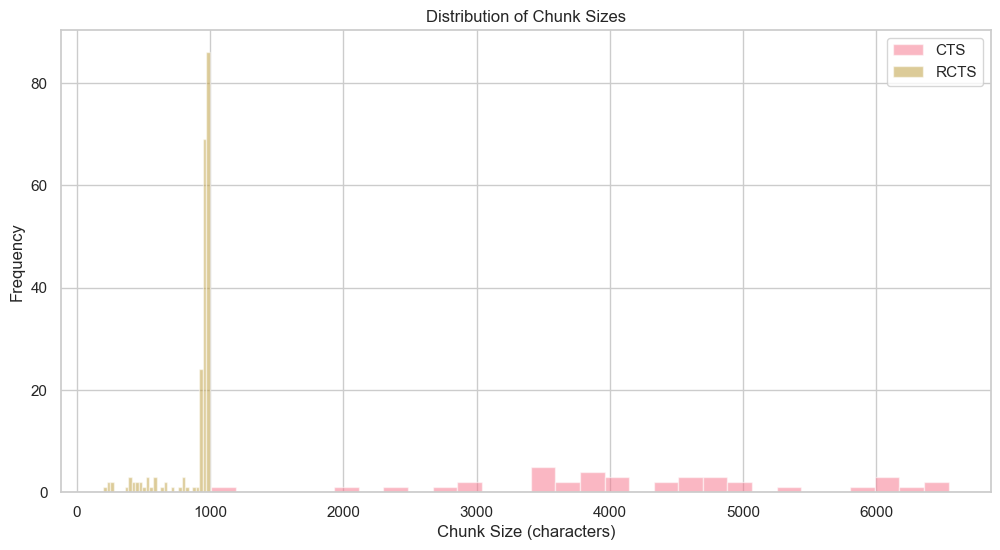

,Metric,CTS,RCTS
0,Average size,4255.6,902.9
1,Minimum size,1010,198
2,Maximum size,6543,1000
3,Standard deviation,1257.7,177.0


C:\Users\Essi_ASUS_STRIX\AppData\Local\Temp\ipykernel_27180\3100790092.py:96: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

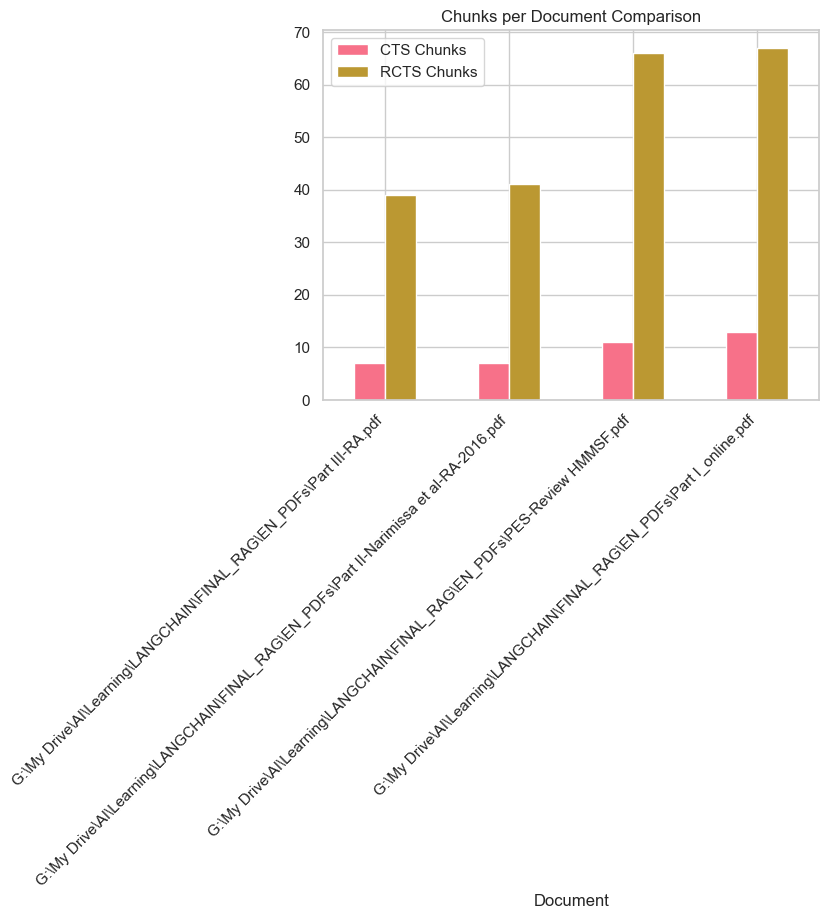

<Figure size 1000x600 with 0 Axes>

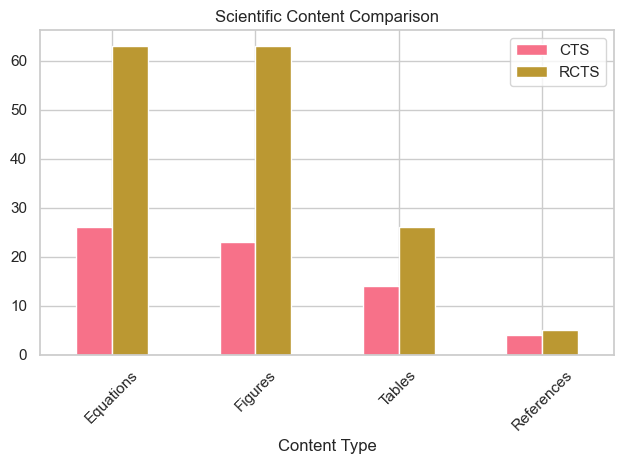

In [ ]:
import chromadb
from collections import defaultdict
import numpy as np
import statistics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style for better notebook visualization
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

def compare_collections(persist_directory: str, cts_name: str, rcts_name: str):
    """
    Interactive comparison of CTS and RCTS collections with visualizations for Jupyter.
    """
    # Connect to ChromaDB
    client = chromadb.PersistentClient(path=persist_directory)
    cts_collection = client.get_collection(cts_name)
    rcts_collection = client.get_collection(rcts_name)
    
    # Get all data
    cts_data = cts_collection.get()
    rcts_data = rcts_collection.get()
    
    # 1. Basic Statistics Display
    print("\n🔍 Basic Statistics:")
    stats_df = pd.DataFrame({
        'Metric': ['Total chunks'],
        'CTS': [len(cts_data['documents'])],
        'RCTS': [len(rcts_data['documents'])]
    })
    display(stats_df)
    
    # 2. Chunk Size Analysis with Distribution Plot
    cts_lengths = [len(chunk) for chunk in cts_data['documents']]
    rcts_lengths = [len(chunk) for chunk in rcts_data['documents']]
    
    plt.figure(figsize=(12, 6))
    plt.hist(cts_lengths, alpha=0.5, label='CTS', bins=30)
    plt.hist(rcts_lengths, alpha=0.5, label='RCTS', bins=30)
    plt.title('Distribution of Chunk Sizes')
    plt.xlabel('Chunk Size (characters)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    # Display chunk statistics
    chunk_stats = pd.DataFrame({
        'Metric': ['Average size', 'Minimum size', 'Maximum size', 'Standard deviation'],
        'CTS': [
            f"{statistics.mean(cts_lengths):.1f}",
            min(cts_lengths),
            max(cts_lengths),
            f"{statistics.stdev(cts_lengths):.1f}"
        ],
        'RCTS': [
            f"{statistics.mean(rcts_lengths):.1f}",
            min(rcts_lengths),
            max(rcts_lengths),
            f"{statistics.stdev(rcts_lengths):.1f}"
        ]
    })
    display(chunk_stats)
    
    # 3. Document Coverage Analysis
    def analyze_coverage(metadatas):
        docs = defaultdict(int)
        pages = defaultdict(set)
        for meta in metadatas:
            source = meta.get('source', '')
            page = meta.get('page', 0)
            if source:
                docs[source] += 1
                pages[source].add(page)
        return docs, pages
    
    cts_docs, cts_pages = analyze_coverage(cts_data['metadatas'])
    rcts_docs, rcts_pages = analyze_coverage(rcts_data['metadatas'])
    
    # Create comparison bar plot for documents
    doc_names = list(set(cts_docs.keys()) | set(rcts_docs.keys()))
    doc_names = [doc.split('/')[-1] for doc in doc_names]  # Just filenames
    
    doc_comparison = pd.DataFrame({
        'Document': doc_names,
        'CTS Chunks': [cts_docs.get(doc, 0) for doc in doc_names],
        'RCTS Chunks': [rcts_docs.get(doc, 0) for doc in doc_names]
    })
    
    plt.figure(figsize=(12, 6))
    doc_comparison.plot(x='Document', y=['CTS Chunks', 'RCTS Chunks'], kind='bar')
    plt.title('Chunks per Document Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 4. Scientific Content Analysis
    def analyze_content(chunks):
        markers = {
            'Equations': ['equation', 'eq.'],
            'Figures': ['figure', 'fig.'],
            'Tables': ['table', 'tab.'],
            'References': ['reference', 'ref.']
        }
        
        results = {}
        for marker_name, terms in markers.items():
            count = sum(1 for chunk in chunks if any(term in chunk.lower() for term in terms))
            results[marker_name] = count
        return results
    
    cts_content = analyze_content(cts_data['documents'])
    rcts_content = analyze_content(rcts_data['documents'])
    
    # Create comparison bar plot for scientific content
    content_df = pd.DataFrame({
        'Content Type': list(cts_content.keys()),
        'CTS': list(cts_content.values()),
        'RCTS': list(rcts_content.values())
    })
    
    plt.figure(figsize=(10, 6))
    content_df.plot(x='Content Type', y=['CTS', 'RCTS'], kind='bar')
    plt.title('Scientific Content Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return cts_data, rcts_data

# Run the comparison
persist_directory = "ChromaDB"  # Your ChromaDB directory
cts_collection_name = "pes-review-hmmsf-pdf"
rcts_collection_name = "pes-review-hmmsf-pdf-RCTS"

cts_data, rcts_data = compare_collections(persist_directory, cts_collection_name, rcts_collection_name)


- **Interpretation and Conclusion:**

1. **Basic Statistics (Total Chunks)**:
   - The **CTS** collection contains **38 chunks**, whereas the **RCTS** collection contains a significantly higher number of **213 chunks**.
   - This indicates that the RCTS collection underwent more aggressive chunking, leading to a finer granularity of data representation.

---

2. **Chunk Size Analysis**:
   - **Average Chunk Size**:
     - CTS: **4255.6 characters**
     - RCTS: **902.9 characters**
   - **Minimum and Maximum Chunk Sizes**:
     - CTS chunks range from **1010 to 6543 characters**, while RCTS chunks range from **198 to 1000 characters**.
   - **Standard Deviation**:
     - CTS chunks exhibit greater variability (**1257.7 characters**) compared to RCTS (**177.0 characters**).

   **Visualization**:
   - The histogram demonstrates a sharp clustering of RCTS chunk sizes below 1000 characters, reflecting uniform and consistent chunking.
   - In contrast, CTS chunks are more spread out, with larger sizes and variability.

   **Interpretation**:
   - The RCTS collection's smaller and more uniform chunks could improve retrieval accuracy for specific queries by ensuring more focused context. However, larger chunks in CTS might retain broader context but risk introducing noise.

---

3. **Chunks per Document**:
   - The bar chart reveals that:
     - RCTS consistently produces **more chunks per document**, with values reaching up to **~70 chunks** for some documents.
     - CTS produces far fewer chunks, typically fewer than **~10 chunks** per document.

   **Interpretation**:
   - The larger number of chunks in RCTS suggests a more granular document representation. This could make the RCTS collection more suitable for precise search and retrieval tasks.

---

4. **Scientific Content Comparison**:
   - The bar chart comparing content types (Equations, Figures, Tables, References) shows:
     - RCTS has significantly higher counts for **Equations**, **Figures**, and **Tables** than CTS.
     - References are minimal in both collections, though slightly higher in CTS.

   **Interpretation**:
   - The dominance of scientific content types (e.g., equations and figures) in RCTS highlights its potential for scientific research use cases where detailed analysis is needed.

---

**Conclusion:**
- The **RCTS collection** offers:
  - More granular and consistent document segmentation compared to **CTS**.
  - A **higher number of chunks**, **smaller average chunk sizes**, and a **more uniform distribution**.
  - Enhanced applicability for tasks requiring **precise retrieval**, such as locating **specific equations or tables**.

- The **CTS collection** provides:
  - **Larger chunk sizes**, which are better suited for tasks that require **broader contextual information**.

- **Recommendation**:
  - **RCTS** is preferable for **fine-grained analysis** and tasks demanding precise content retrieval.
  - **CTS** is ideal for tasks where retaining a broader context is advantageous.

## A.2 Vectore Embeddings: OpenAI vs. BGE 

To compare the robustness of the two embedding methods (OpenAI vs. BGE embeddings) on the same chunks, we can use **quantitative and qualitative metrics**. Here's a step-by-step plan to evaluate their performance systematically:


- **Define Metrics for Comparison** 


1. **Similarity Consistency**:
   - Measure how consistent the embeddings are when similar queries are made.
   - Metric: Average cosine similarity between embeddings of the same chunks across collections.

2. **Search Quality**:
   - Test embedding quality using known ground-truth queries and measure retrieval relevance.
   - Metric: Precision@k and Recall@k on a set of predefined queries and expected responses.

3. **Clustering Behavior**:
   - Analyze the clustering quality of embeddings.
   - Metric: Compare clustering coherence using silhouette scores or Davies-Bouldin indices.

4. **Scientific Content Focus**:
   - Check how well embeddings capture scientific terms (e.g., equations, tables).
   - Metric: Correlation between embeddings' semantic similarity and human evaluations.



### A.2.1 Similarity Consistency Analysis

In this analysis, we evaluated the **internal consistency** of embeddings generated by OpenAI and BGE models within their respective embedding spaces. This was achieved by calculating the pairwise cosine similarities between embeddings of chunks originating from the same source document. The goal was to assess how well each embedding model preserves semantic coherence and clustering for related content.

Key steps in the analysis:
1. **Embedding Extraction**:
   - Retrieved embeddings and associated metadata from ChromaDB collections for OpenAI (`pes-review-hmmsf-pdf-RCTS`) and BGE (`pes-review-hmmsf-pdf-RCTS-BGE`).
   
2. **Within-Space Similarity Calculation**:
   - Computed cosine similarities between embeddings of chunks belonging to the same source document.
   - Evaluated **average similarity** and **standard deviation** to measure **coherence** and **variability** within each embedding space.

3. **Comparing Statistical Metrics**:
   - Used **average similarity** to measure the overall clustering tendency within the embedding space.
   - Used **standard deviation** to assess the variability of similarities, reflecting the consistency of embeddings within the space. 

This approach provides quantitative metrics for assessing the internal coherence and clustering behavior of each embedding model.


Computing within-space similarities for OpenAI embeddings...
Computing within-space similarities for BGE embeddings...

OpenAI - Average Similarity: 0.6096, Std Dev: 0.1002
BGE - Average Similarity: 0.8041, Std Dev: 0.0574


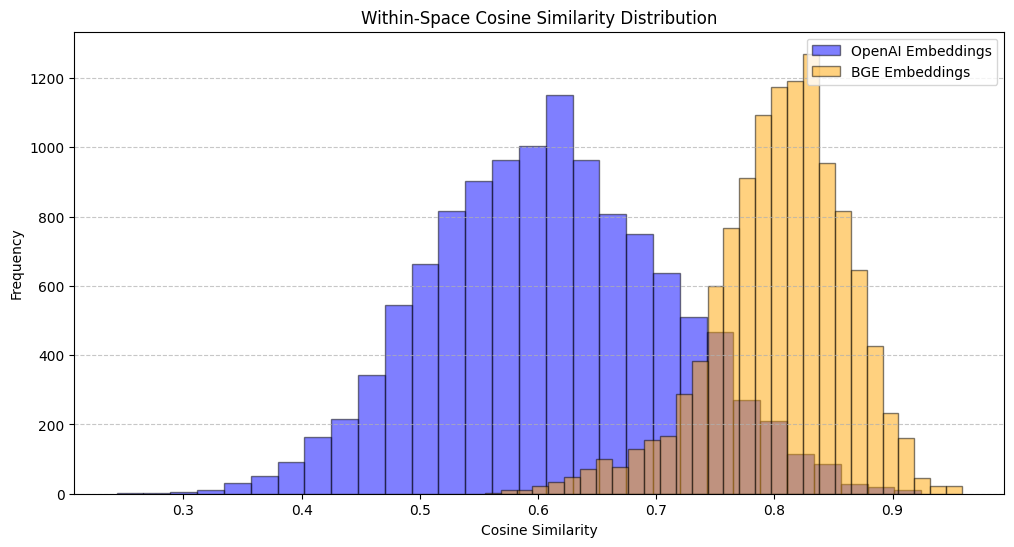

In [ ]:
import os
import numpy as np
import chromadb
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Set paths and collection names
persist_directory = r"G:\My Drive\AI\Learning\LANGCHAIN\FINAL_RAG\ChromaDB"  # Ensure correct path
openai_collection_name = "pes-review-hmmsf-pdf-RCTS"
bge_collection_name = "pes-review-hmmsf-pdf-RCTS-BGE"

# Connect to ChromaDB
client = chromadb.PersistentClient(path=persist_directory)

# Fetch collections with metadata and embeddings
openai_data = client.get_collection(openai_collection_name).get(include=["embeddings", "metadatas"])
bge_data = client.get_collection(bge_collection_name).get(include=["embeddings", "metadatas"])

# Debugging: Check metadata retrieval
if not openai_data["metadatas"] or not bge_data["metadatas"]:
    raise ValueError("Metadata is empty or not properly stored.")

# Extract embeddings and sources
openai_embeddings = np.array(openai_data["embeddings"])
bge_embeddings = np.array(bge_data["embeddings"])
openai_sources = [meta["source"] for meta in openai_data["metadatas"] if meta and "source" in meta]
bge_sources = [meta["source"] for meta in bge_data["metadatas"] if meta and "source" in meta]

# Ensure metadata consistency
assert len(openai_embeddings) == len(openai_sources), "Mismatch between OpenAI embeddings and sources."
assert len(bge_embeddings) == len(bge_sources), "Mismatch between BGE embeddings and sources."

# Compute within-space similarities
def compute_within_space_similarities(embeddings, chunk_sources):
    similarity_scores = []
    for i, source in enumerate(chunk_sources):
        for j in range(len(chunk_sources)):
            if chunk_sources[i] == chunk_sources[j] and i != j:
                similarity = cosine_similarity(embeddings[i].reshape(1, -1), embeddings[j].reshape(1, -1))[0][0]
                similarity_scores.append(similarity)
    return similarity_scores

print("\nComputing within-space similarities for OpenAI embeddings...")
openai_similarities = compute_within_space_similarities(openai_embeddings, openai_sources)

print("Computing within-space similarities for BGE embeddings...")
bge_similarities = compute_within_space_similarities(bge_embeddings, bge_sources)

# Analyze results
openai_avg_similarity = np.mean(openai_similarities)
openai_std_dev_similarity = np.std(openai_similarities)
bge_avg_similarity = np.mean(bge_similarities)
bge_std_dev_similarity = np.std(bge_similarities)

print(f"\nOpenAI - Average Similarity: {openai_avg_similarity:.4f}, Std Dev: {openai_std_dev_similarity:.4f}")
print(f"BGE - Average Similarity: {bge_avg_similarity:.4f}, Std Dev: {bge_std_dev_similarity:.4f}")

# Visualize similarity distributions
plt.figure(figsize=(12, 6))
plt.hist(openai_similarities, bins=30, alpha=0.5, label="OpenAI Embeddings", color="blue", edgecolor="black")
plt.hist(bge_similarities, bins=30, alpha=0.5, label="BGE Embeddings", color="orange", edgecolor="black")
plt.title("Within-Space Cosine Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


**Summary of Results**

**OpenAI Embeddings**:
- **Average Similarity**: 0.6096  
- **Standard Deviation**: 0.1002  
- **Key Traits**:
  - Broader similarity distribution, capturing semantic diversity and nuances.
  - Lower internal consistency, which may weaken clustering performance for related content.

**BGE Embeddings**:
- **Average Similarity**: 0.8041  
- **Standard Deviation**: 0.0574  
- **Key Traits**:
  - Higher internal coherence with tighter clustering of related chunks.
  - Limited semantic diversity compared to OpenAI embeddings.

**Comparison**:
- **OpenAI**: Suitable for tasks requiring diversity and nuance, like exploratory queries and summarization.
- **BGE**: Better for precision and structured content retrieval, such as grouping related figures, tables, or equations.

---

**Analysis for PDF RAG Pipeline**

**Key Requirements for Scientific PDFs**:
1. **High precision**: Retrieve all relevant content (e.g., equations, figures).
   - **BGE** excels due to strong clustering and coherence.
2. **Context preservation**: Handle broad queries (e.g., "Summarize the methodology").
   - **OpenAI** performs better with its ability to capture nuanced relationships.
3. **Clustering performance**: Group related chunks effectively (e.g., all text for "Figure 3").
   - **BGE**'s tighter clustering outperforms OpenAI here.

---
**Practical Implications**

- **BGE Embeddings**:
  - Ideal for precision-driven retrieval tasks in structured PDFs, such as retrieving content tied to equations, tables, or figures.
  - Recommended for domain-specific pipelines requiring internal consistency.
- **OpenAI Embeddings**:
  - Useful for exploratory queries needing semantic flexibility and broad contextual understanding.
  - May struggle with tasks requiring strict grouping of structured content.

---

**Conclusion and Recommendation**

For scientific PDFs with complex structures, **BGE Embeddings** are the superior choice for precision and structured retrieval. Use **OpenAI Embeddings** as a complementary model for tasks requiring semantic diversity and exploratory analysis. This combined strategy ensures both **precision** and **flexibility** for diverse retrieval needs.